In [157]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, classification_report
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
df_feature_selected = pd.read_csv('df_feature_selected.csv')
X = df_feature_selected[['ad_creation_time', 'estimated_audience_size', 'spend', 'region_with_highest_percentage','age_with_highest_percentage','gender_highest_percentage', 'publisher_platforms_str','page_name','bodies_joined','descriptions_joined','titles_joined','cleaned_captions']]
y = df_feature_selected[['impressions']]

df_feature_selected['bodies_joined'] = df_feature_selected['bodies_joined'].fillna('').astype(str)
df_feature_selected['descriptions_joined'] = df_feature_selected['descriptions_joined'].fillna('').astype(str)
df_feature_selected['titles_joined'] = df_feature_selected['titles_joined'].fillna('').astype(str)

In [202]:
feature_list = ['estimated_audience_size','spend','age_with_highest_percentage','year','month', 
'day','cleaned_captions_freq','page_name_freq','region_with_highest_percentage_Australian Capital Territory',
'region_with_highest_percentage_New South Wales','region_with_highest_percentage_Northern Territory','region_with_highest_percentage_Queensland',
'region_with_highest_percentage_South Australia','region_with_highest_percentage_Tasmania','region_with_highest_percentage_Unknown',
'region_with_highest_percentage_Victoria','region_with_highest_percentage_Western Australia','gender_highest_percentage_Unknown',
'gender_highest_percentage_female','gender_highest_percentage_male','gender_highest_percentage_unknown','publisher_platforms_str_facebook','publisher_platforms_str_facebook, instagram', 'publisher_platforms_str_instagram']                          

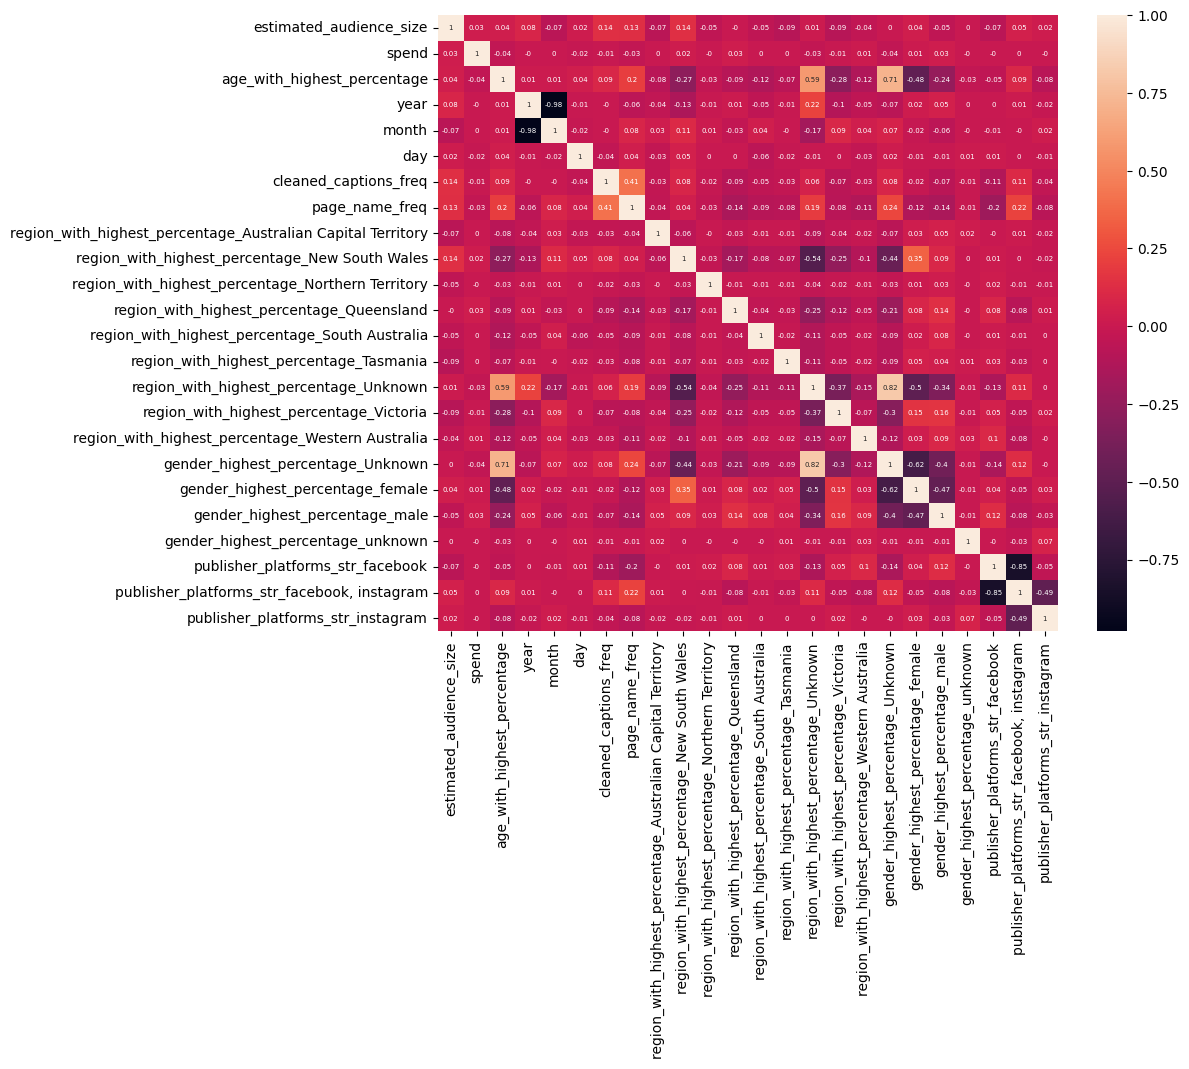

In [203]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(X[feature_list].corr().round(2), annot=True, annot_kws={"size": 5})  # 'annot=True' to show the correlation values in the cells
plt.show()

In [212]:
for idx, value in enumerate(y['impressions']):
    if value < 50000:
        y['impressions'][idx] = "Under 50k"
    else:
        y['impressions'][idx] = "Over 50k"

/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20475/2148472755.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  y['impressions'][idx] = "Under 50k"
/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20475/2148472755.p

In [213]:
X['ad_creation_time'] = pd.to_datetime(X['ad_creation_time'])

# Extracting date components
X['year'] = X['ad_creation_time'].dt.year
X['month'] = X['ad_creation_time'].dt.month
X['day'] = X['ad_creation_time'].dt.day
X = X.drop(['ad_creation_time'], axis=1)

/var/folders/jb/tfwdgvdn69n2mpzr99z3z1400000gn/T/ipykernel_20475/262294503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ad_creation_time'] = pd.to_datetime(X['ad_creation_time'])


In [214]:
lb_enc = LabelEncoder()
oh_enc = OneHotEncoder()
scaler = StandardScaler()

X['estimated_audience_size'] = scaler.fit_transform(X[['estimated_audience_size']])
X['spend'] = scaler.fit_transform(X[['spend']])

X['age_with_highest_percentage'] = lb_enc.fit_transform(X[['age_with_highest_percentage']])

caption_frequencies = X['cleaned_captions'].value_counts(normalize=True)  # normalize=True gives the proportion
X['cleaned_captions_freq'] = X['cleaned_captions'].map(caption_frequencies)
X = X.drop(['cleaned_captions'], axis=1)

caption_frequencies = X['page_name'].value_counts(normalize=True)  # normalize=True gives the proportion
X['page_name_freq'] = X['page_name'].map(caption_frequencies)
X = X.drop(['page_name'], axis=1)


oh_enc = OneHotEncoder()
columns_to_encode = ['region_with_highest_percentage', 'gender_highest_percentage', 'publisher_platforms_str']
encoded_data = oh_enc.fit_transform(X[columns_to_encode])
new_columns = oh_enc.get_feature_names_out(columns_to_encode)
encoded_data_dense = encoded_data.toarray()
encoded_df = pd.DataFrame(encoded_data_dense, columns=new_columns)
X = X.drop(columns=columns_to_encode)
X = pd.concat([X, encoded_df], axis=1)

/Users/ayoucruz/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-100") 

[==================================================] 100.0% 128.1/128.1MB downloaded


In [219]:
y[0:5]

,impressions
0,Under 50k
1,Over 50k
2,Under 50k
3,Under 50k
4,Under 50k


In [103]:
# Define a function to replace non-array entries with zero-filled arrays
def standardize_entry(entry, length=100):
    if isinstance(entry, np.ndarray):
        return entry
    else:
        return np.zeros(length)

def document_vector(doc):
    # Convert document to list of words, assuming doc is a string
    words = doc.split()
    # Remove out-of-vocabulary words
    words = [word for word in words if word in glove_model]
    # Check if there are any words left after filtering
    if not words:
        return np.zeros(glove_model.vector_size)
    # Return the mean of the embeddings
    return np.mean(glove_model[words], axis=0)

def expand_vectors(df, column_name):
    # Assuming the vectors are stored as lists in the dataframe
    vector_df = pd.DataFrame(df[column_name].tolist())
    vector_df.columns = [f"{column_name}_{i}" for i in range(vector_df.shape[1])]
    df = pd.concat([df.drop(columns=[column_name]), vector_df], axis=1)
    return df

In [104]:
# Apply the function to the text columns
X['bodies_vec'] = df_feature_selected['bodies_joined'].apply(document_vector)
X['descriptions_vec'] = df_feature_selected['descriptions_joined'].apply(document_vector)
X['titles_vec'] = df_feature_selected['titles_joined'].apply(document_vector)
X = X.drop(['bodies_joined', 'descriptions_joined', 'titles_joined'], axis=1)

In [105]:
X['descriptions_vec'] = X['descriptions_vec'].apply(standardize_entry)

X = expand_vectors(X, 'bodies_vec')
X = expand_vectors(X, 'descriptions_vec')
X = expand_vectors(X, 'titles_vec')

In [210]:
y[0:5]

,impressions
0,500.0
1,55000.0
2,8500.0
3,3500.0
4,500.0


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [126]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

/Users/ayoucruz/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [127]:
y_pred = rf.predict(X_test)

In [135]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred, pos_label='Over 50k'))
print("Precision: ", precision_score(y_test, y_pred, pos_label='Over 50k'))
print("F1-score: ", f1_score(y_test, y_pred, pos_label='Over 50k'))

Accuracy:  0.9988836793927216
Recall:  0.6428571428571429
Precision:  1.0
F1-score:  0.782608695652174


In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Over 50k       1.00      0.64      0.78        28
   Under 50k       1.00      1.00      1.00      8930

    accuracy                           1.00      8958
   macro avg       1.00      0.82      0.89      8958
weighted avg       1.00      1.00      1.00      8958



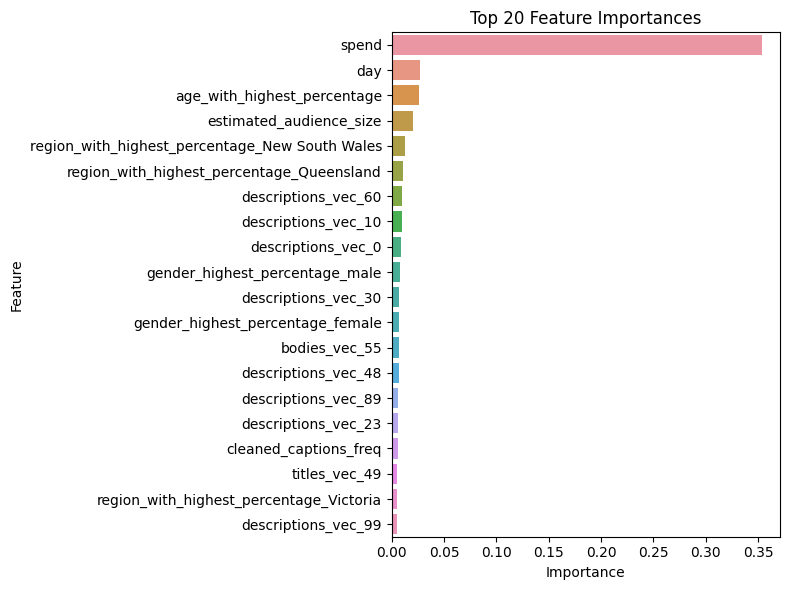

In [148]:
importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices][:20]  # Top 20 features
sorted_importances = importances[indices][:20]  # Top 20 importances

# Create a DataFrame to facilitate plotting with seaborn
feature_importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})

# Plot the top 20 feature importances using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, orient='h')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()  # Adjust layout to make room for feature names
plt.show()

In [199]:
X

,estimated_audience_size,spend,age_with_highest_percentage,bodies_joined,descriptions_joined,titles_joined,year,month,day,cleaned_captions_freq,...,region_with_highest_percentage_Unknown,region_with_highest_percentage_Victoria,region_with_highest_percentage_Western Australia,gender_highest_percentage_Unknown,gender_highest_percentage_female,gender_highest_percentage_male,gender_highest_percentage_unknown,publisher_platforms_str_facebook,"publisher_platforms_str_facebook, instagram",publisher_platforms_str_instagram
0,-1.380702,-0.050546,1,international day girl empower girls education...,acknowledge first nations people australia cus...,one girl page found,2023,10,1,0.000558,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.636975,0.956464,2,reasons say voice,reasons say voice,know say,2023,10,1,0.005426,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.636975,-0.050546,2,reasons say voice,reasons say voice,know say,2023,10,1,0.005426,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.636975,-0.050546,2,voice legally risky unknown consequences would...,labor voice legally risky unknown consequences...,know say,2023,10,1,0.005426,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.480665,-0.050546,5,rapid growth nfts largely worthless bored ape ...,two traded sets nfts bored apes collection cre...,majority nfts estimated worthless,2023,10,1,0.027084,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44781,1.101579,-0.050546,7,need support queensland renewable energy targe...,take action today,send email david crisafulli,2024,3,20,0.000380,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
44782,1.101579,-0.050546,2,need support queensland climate clean energy t...,take action today,send email david crisafulli,2024,3,20,0.000380,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
44783,1.101579,-0.050546,1,need support queensland climate clean energy t...,take action today,send email david crisafulli,2024,3,20,0.000380,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
44784,1.101579,-0.050546,1,need support queensland renewable energy targe...,take action today,send email david crisafulli,2024,3,20,0.000380,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


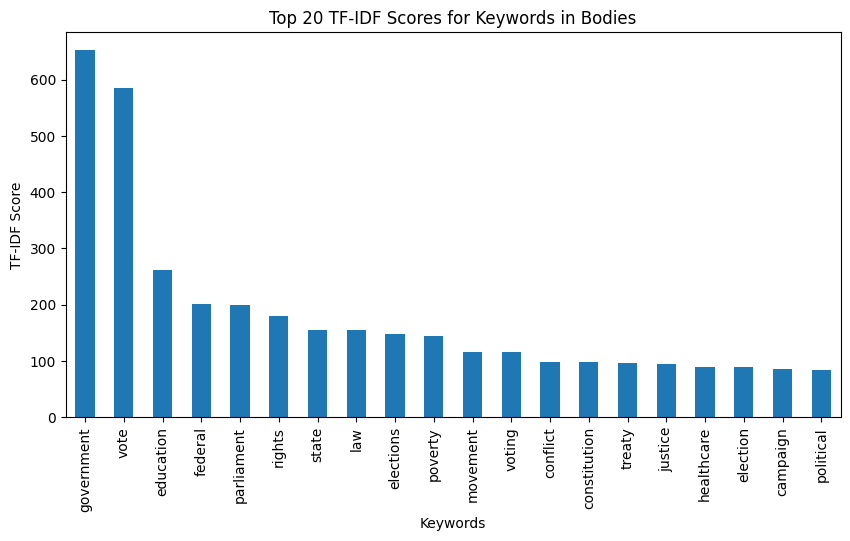

In [240]:
keywords = [
    'election', 'government', 'policy', 'vote', 'democracy', 'legislation', 'senate', 'congress', 'parliament', 
    'president', 'prime minister', 'diplomacy', 'regulation', 'rights', 'justice', 'law', 'reform', 'candidate', 
    'party', 'campaign', 'debate', 'constitution', 'bill', 'state', 'federal', 'civic', 'protest', 'movement', 
    'elections', 'voting', 'political', 'governance', 'citizenship', 'activism', 'ideology', 'treaty', 'alliance', 
    'conflict', 'healthcare', 'education', 'taxation', 'climate change', 'global warming', 'sustainability', 
    'renewable energy', 'conservation', 'pollution', 'green energy', 'carbon footprint', 'recycling', 'deforestation', 
    'social justice', 'inequality', 'human rights', 'immigration', 'gender equality', 'LGBTQ', 'racial equality', 
    'civil rights', 'poverty', 'unemployment', 'pandemic', 'COVID-19', 'mental health', 'vaccination', 
    'healthcare reform', 'nutrition', 'fitness', 'obesity', 'smoking', 'disease prevention', 'artificial intelligence', 
    'blockchain', 'cybersecurity', 'data privacy', 'machine learning', 'drones', '5G', 'internet of things', 
    'smart cities', 'virtual reality', 'trade war', 'stock market', 'inflation', 'economic growth', 'cryptocurrency', 
    'fiscal policy', 'tax reform', 'minimum wage', 'wealth distribution', 'terrorism', 'nuclear weapons', 
    'international trade', 'foreign policy', 'world peace', 'humanitarian crisis', 'UN', 'NATO', 'EU', 'globalization'
]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_feature_selected['bodies_joined'])

feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

political_tfidf = tfidf_df[[word for word in keywords if word in tfidf_df.columns]]
political_tfidf_sum = political_tfidf.sum(axis=0).sort_values(ascending=False)[0:20]
plt.figure(figsize=(10, 5))
political_tfidf_sum.plot(kind='bar')
plt.title('Top 20 TF-IDF Scores for Keywords in Bodies')
plt.xlabel('Keywords')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=90)
plt.show()

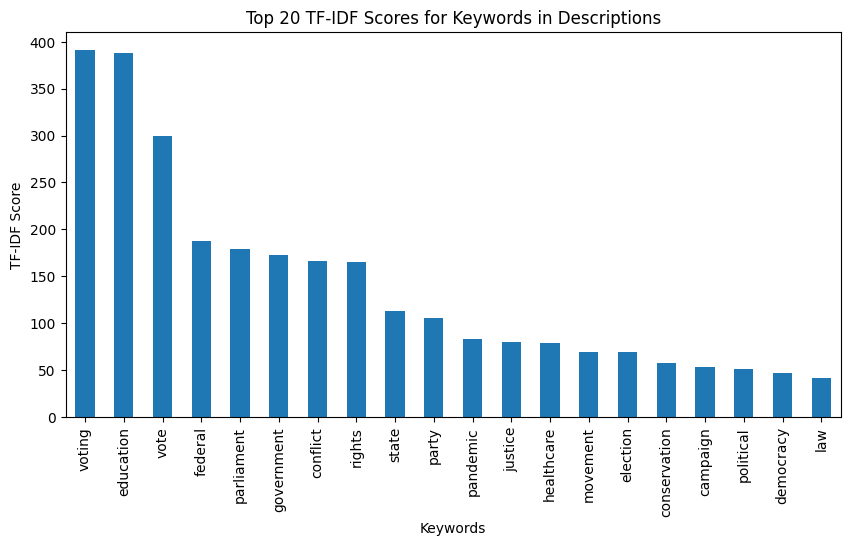

In [243]:
tfidf_matrix = vectorizer.fit_transform(df_feature_selected['descriptions_joined'])

feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

political_tfidf = tfidf_df[[word for word in keywords if word in tfidf_df.columns]]
political_tfidf_sum = political_tfidf.sum(axis=0).sort_values(ascending=False)[0:20]
plt.figure(figsize=(10, 5))
political_tfidf_sum.plot(kind='bar')
plt.title('Top 20 TF-IDF Scores for Keywords in Descriptions')
plt.xlabel('Keywords')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=90)
plt.show()

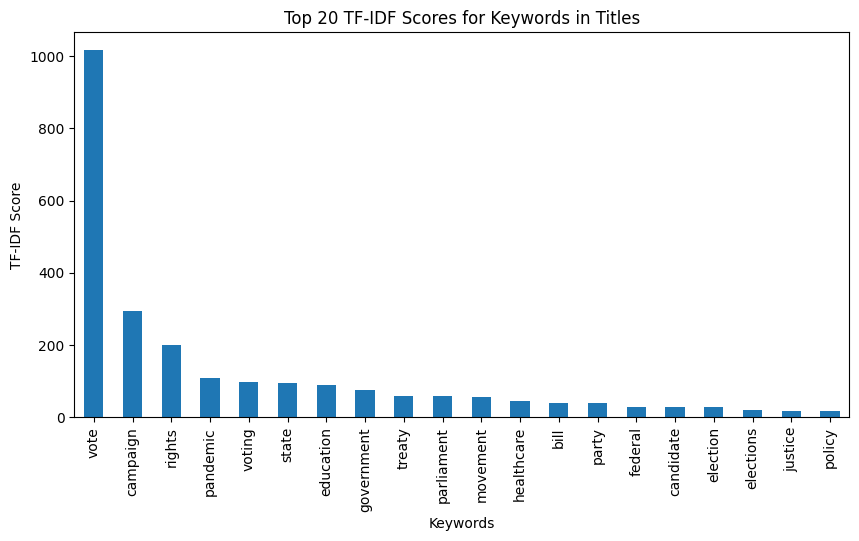

In [244]:
tfidf_matrix = vectorizer.fit_transform(df_feature_selected['titles_joined'])

feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

political_tfidf = tfidf_df[[word for word in keywords if word in tfidf_df.columns]]
political_tfidf_sum = political_tfidf.sum(axis=0).sort_values(ascending=False)[0:20]
plt.figure(figsize=(10, 5))
political_tfidf_sum.plot(kind='bar')
plt.title('Top 20 TF-IDF Scores for Keywords in Titles')
plt.xlabel('Keywords')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=90)
plt.show()